<a href="https://colab.research.google.com/github/brianellis1997/Sarcasm_Detection/blob/Lindsey/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/brianellis1997/Sarcasm_Detection.git

Cloning into 'Sarcasm_Detection'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 134 (delta 71), reused 116 (delta 62), pack-reused 3
Receiving objects: 100% (134/134), 2.96 MiB | 25.24 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
train_bal = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/train_bal_2.csv')

In [4]:
train_bal

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,exclamation_count,questionmark_count,period_count,space_count,slash_count,elips_count,capital_letters_count,word_count,total_punctuation
0,522142,0,"I personally wasn't a huge Garrosh fan, I've a...",cromemako83,AskReddit,2,2,0,2015-07-01,2015-07-11 01:55:53,Fuck Vol'jin. Garrosh Hellscream did nothing w...,0,0,1,0,0,0,5,14,4
1,907864,1,you forgot the,_SharkWeek_,AskReddit,1,1,0,2013-03-01,2013-03-14 03:03:46,That's a lie fed to you by the LIEberal media....,0,0,0,0,0,0,0,3,0
2,604170,1,"Nah man, she's clearly an ad carry",jdswift13,leagueoflegends,1,1,0,2015-10-01,2015-10-21 23:22:17,she isnt already?,0,0,0,0,0,0,1,7,2
3,110635,1,This sub in a nutshell.,trickz-M-,GlobalOffensive,1,-1,-1,2016-12-01,2016-12-05 03:50:18,Cloud 9 Qualify! (ONLY C9 FANS ALLOWED(,0,0,1,0,0,0,1,5,1
4,997758,0,Yes... I do.,guriboysf,videos,4,4,0,2010-01-01,2010-01-17 21:32:40,"""so, i hear you have a fat cock.""",0,0,4,0,0,0,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808613,368312,1,"Yeah, all asians are smart, right?",est1roth,europe,2,2,0,2016-04-01,2016-04-17 00:05:51,"Well if an asian woman says it, it must be true.",0,1,0,0,0,0,1,6,3
808614,541588,1,Nah I was serious,SrrBrrGrr,funny,-5,-5,0,2015-08-01,2015-08-11 23:15:11,I don't think people understand you were jokin...,0,0,0,0,0,0,2,4,0
808615,833824,0,you are assuming way too much there is no liab...,cqm,blog,1,1,0,2014-09-01,2014-09-30 21:44:06,They're not saying it is easy. In fact they we...,0,0,0,0,0,0,0,41,6
808616,55102,1,But Planned Parenthood is the devil and must b...,DrScientist812,worldnews,3,3,0,2016-09-01,2016-09-06 12:40:25,Fall in ovarian cancer deaths worldwide linked...,1,0,0,0,0,0,3,13,1


In [5]:
import re, string, time, nltk
import numpy as np
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords as stopwordprovider
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808618 entries, 0 to 808617
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Unnamed: 0             808618 non-null  int64 
 1   label                  808618 non-null  int64 
 2   comment                808618 non-null  object
 3   author                 808618 non-null  object
 4   subreddit              808618 non-null  object
 5   score                  808618 non-null  int64 
 6   ups                    808618 non-null  int64 
 7   downs                  808618 non-null  int64 
 8   date                   808618 non-null  object
 9   created_utc            808618 non-null  object
 10  parent_comment         808618 non-null  object
 11  exclamation_count      808618 non-null  int64 
 12  questionmark_count     808618 non-null  int64 
 13  period_count           808618 non-null  int64 
 14  space_count            808618 non-null  int64 
 15  

In [7]:
y = train_bal['label']
X = train_bal.drop(columns=['label'])

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [10]:
y_train.shape[0]

646894

In [11]:
X_train.shape[0]

646894

In [12]:
X_text = X_train[['comment', 'parent_comment']]
X_numeric = X_train[['word_count', 'capital_letters_count', 'total_punctuation', 'score']] # add brians feature engineering

In [13]:
X_numeric.shape[0]

646894

In [14]:
X_text.shape[0]

646894

In [15]:
max_words = 10000  # Maximum number of words to keep based on word frequency
max_seq_length = 100  # Maximum length of sequences

In [16]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, concatenate, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text['comment'] + ' ' + X_text['parent_comment'])

In [17]:
X_text_comment_seq = tokenizer.texts_to_sequences(X_text['comment'])
X_text_parent_comment_seq = tokenizer.texts_to_sequences(X_text['parent_comment'])

In [18]:
len(X_text_parent_comment_seq)

646894

In [19]:
len(X_text_comment_seq)

646894

In [20]:
y_train.shape[0]

646894

In [21]:
X_text_comment_pad = pad_sequences(X_text_comment_seq, maxlen=max_seq_length)
X_text_parent_comment_pad = pad_sequences(X_text_parent_comment_seq, maxlen=max_seq_length)

In [22]:
len(X_text_comment_pad)

646894

In [23]:
len(X_text_parent_comment_pad)

646894

In [24]:
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

In [25]:
X_numeric_scaled.shape[0]

646894

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 comment_input (InputLayer)  [(None, 100)]                0         []                            
                                                                                                  
 parent_comment_input (Inpu  [(None, 100)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 embedding_3 (Embedding)     (None, 100, 100)             1000000   ['comment_input[0][0]',       
                                                                     'parent_comment_input[0][0]']
                                                                                            

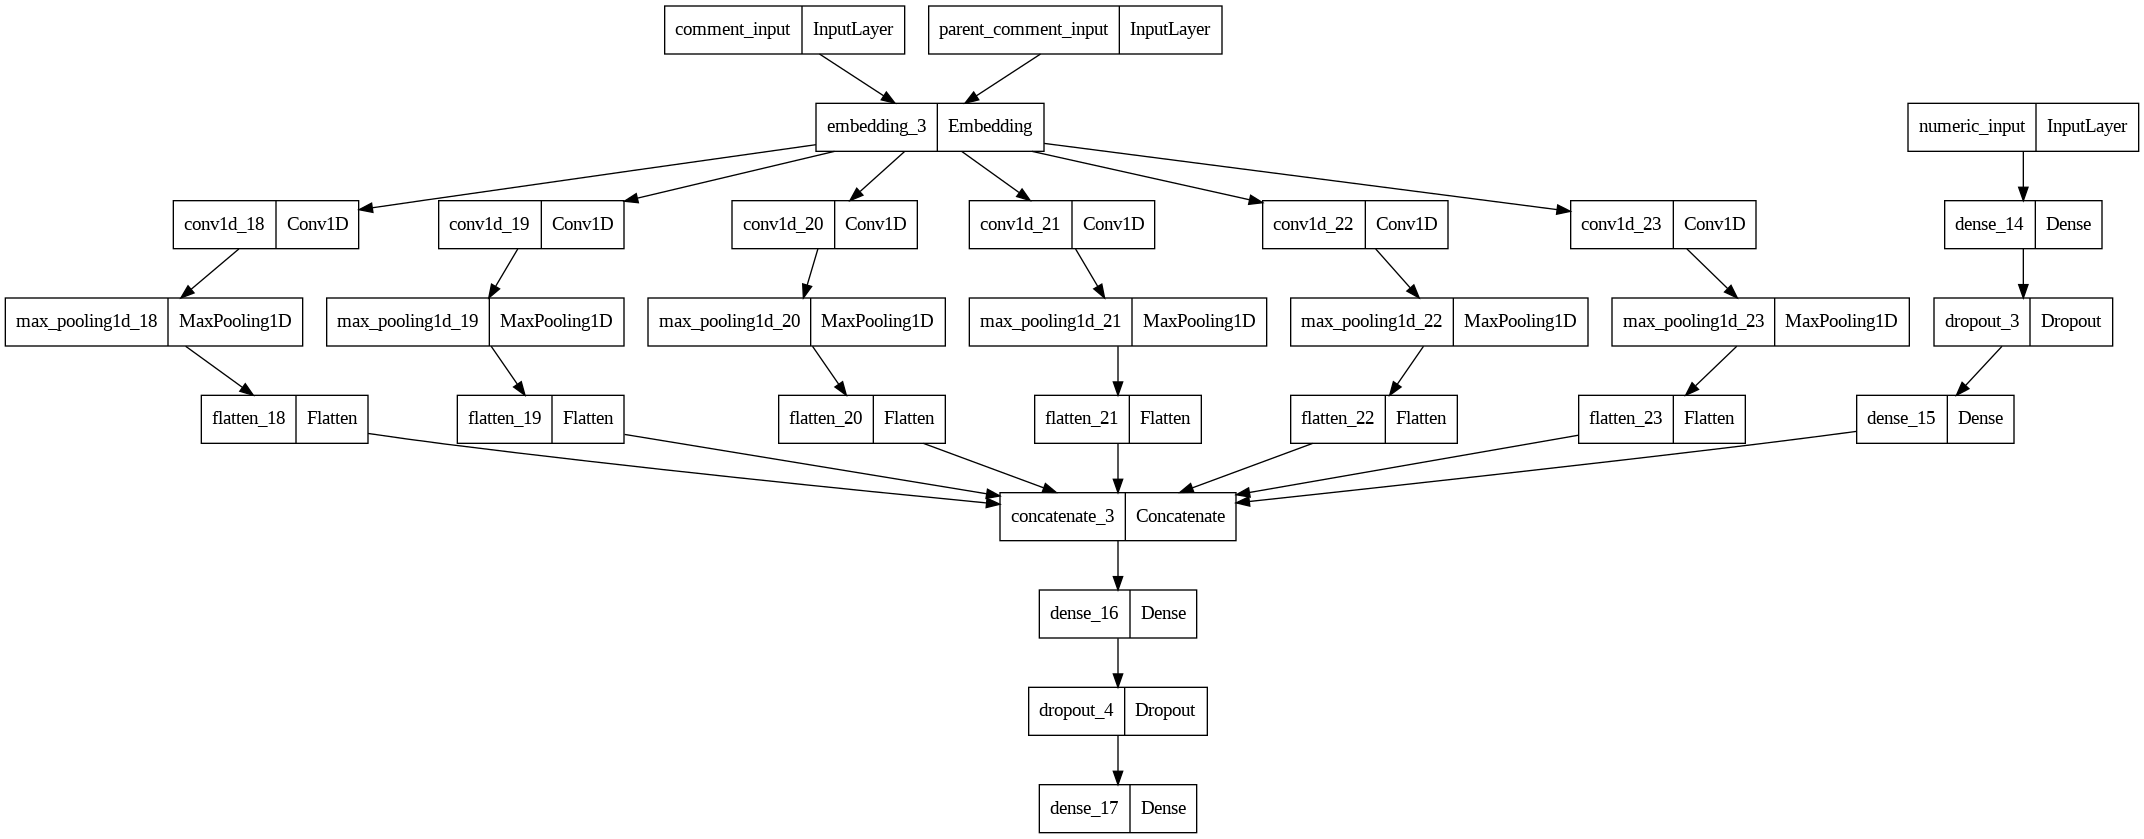

In [41]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout
from keras.models import Model



# tune pooling size
pool_size = 2

# smaller batch size for memory purposes
batch_size = 32

# Three model inputs so far
comment_input = Input(shape=(max_seq_length,), name='comment_input')
parent_comment_input = Input(shape=(max_seq_length,), name='parent_comment_input')
numeric_input = Input(shape=(X_numeric_scaled.shape[1],), name='numeric_input')

embedding_dim = 100
num_filters = 128
filter_sizes = [3, 4, 5]

embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_length)
comment_embedding = embedding_layer(comment_input)
parent_comment_embedding = embedding_layer(parent_comment_input)

conv_blocks = []
for filter_size in filter_sizes:
    conv_comment = Conv1D(filters=num_filters,
                          kernel_size=filter_size,
                          padding='valid',
                          activation='relu',
                          strides=1)(comment_embedding)
    conv_parent_comment = Conv1D(filters=num_filters,
                                 kernel_size=filter_size,
                                 padding='valid',
                                 activation='relu',
                                 strides=1)(parent_comment_embedding)

    max_pool_comment = MaxPooling1D(pool_size=max_seq_length - filter_size + 1)(conv_comment)
    max_pool_parent_comment = MaxPooling1D(pool_size=max_seq_length - filter_size + 1)(conv_parent_comment)

    conv_blocks.append(max_pool_comment)
    conv_blocks.append(max_pool_parent_comment)


# numeric_dense = Dense(64, activation='relu')(numeric_input)
# numeric_dense = Dense(32, activation='relu')(numeric_dense)


flatten_tensors = [Flatten()(tensor) for tensor in conv_blocks]


numeric_dense = Dense(64, activation='relu')(numeric_input)
numeric_dense = Dropout(0.5)(numeric_dense)
numeric_dense = Dense(32, activation='relu')(numeric_dense)



concatenated_final = concatenate(flatten_tensors + [numeric_dense], axis=-1)


dense = Dense(128, activation='relu')(concatenated_final)
dense = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(dense)


model1 = Model(inputs=[comment_input, parent_comment_input, numeric_input], outputs=output)

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()
plot_model(model1)






In [27]:
X_text_test = X_test[['comment', 'parent_comment']]
X_numeric_test = X_test[['word_count', 'capital_letters_count', 'total_punctuation', 'score']] # add brians feature engineering

In [28]:
X_text_comment_seq_test = tokenizer.texts_to_sequences(X_text_test['comment'])
X_text_parent_comment_seq_test = tokenizer.texts_to_sequences(X_text_test['parent_comment'])

In [29]:
X_text_comment_pad_test = pad_sequences(X_text_comment_seq_test, maxlen=max_seq_length)
X_text_parent_comment_pad_test = pad_sequences(X_text_parent_comment_seq_test, maxlen=max_seq_length)

In [30]:
scaler = StandardScaler()
X_numeric_scaled_test = scaler.fit_transform(X_numeric_test)

In [31]:
y_train.shape[0]

646894

In [32]:
len(X_text_comment_pad)

646894

In [42]:
model1.fit({'comment_input': X_text_comment_pad, 'parent_comment_input': X_text_parent_comment_pad, 'numeric_input': X_numeric_scaled}, y_train, epochs=4, batch_size=batch_size, validation_split=0.1)




Epoch 1/4
18194/18194 [==============================] - 152s 8ms/step - loss: 0.5644 - accuracy: 0.7085 - val_loss: 0.5448 - val_accuracy: 0.7203
Epoch 2/4
18194/18194 [==============================] - 125s 7ms/step - loss: 0.5199 - accuracy: 0.7442 - val_loss: 0.5406 - val_accuracy: 0.7277
Epoch 3/4
18194/18194 [==============================] - 125s 7ms/step - loss: 0.4781 - accuracy: 0.7711 - val_loss: 0.5536 - val_accuracy: 0.7236
Epoch 4/4
18194/18194 [==============================] - 122s 7ms/step - loss: 0.4273 - accuracy: 0.8001 - val_loss: 0.5742 - val_accuracy: 0.7158


In [37]:
loss, accuracy = model1.evaluate({'comment_input': X_text_comment_pad_test,
                                 'parent_comment_input': X_text_parent_comment_pad_test,
                                 'numeric_input': X_numeric_scaled_test},
                                y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


5054/5054 [==============================] - 15s 3ms/step - loss: 0.5888 - accuracy: 0.7039
Test Loss: 0.588805615901947
Test Accuracy: 0.703933835029602


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Model

predictions = model1.predict({'comment_input': X_text_comment_pad_test,
                             'parent_comment_input': X_text_parent_comment_pad_test,
                             'numeric_input': X_numeric_scaled_test})

prediction_result = (predictions > 0.5).astype('int32')

accuracy = accuracy_score(y_test, prediction_result)
print('Accuracy: %f' % accuracy)


precision = precision_score(y_test, prediction_result)
print('Precision: %f' % precision)


recall = recall_score(y_test, prediction_result)
print('Recall: %f' % recall)


f1 = f1_score(y_test, prediction_result)
print('F1 score: %f' % f1)


predictions = predictions.flatten()
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)




5054/5054 [==============================] - 11s 2ms/step
Accuracy: 0.704558
Precision: 0.693029
Recall: 0.737353
F1 score: 0.714504
ROC AUC: 0.781382


#Build CNN with comment and parent comment


#CNN Model 2

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 comment_input (InputLayer)  [(None, 100)]                0         []                            
                                                                                                  
 parent_comment_input (Inpu  [(None, 100)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 embedding_5 (Embedding)     (None, 100, 100)             1000000   ['comment_input[0][0]',       
                                                                     'parent_comment_input[0][0]']
                                                                                            

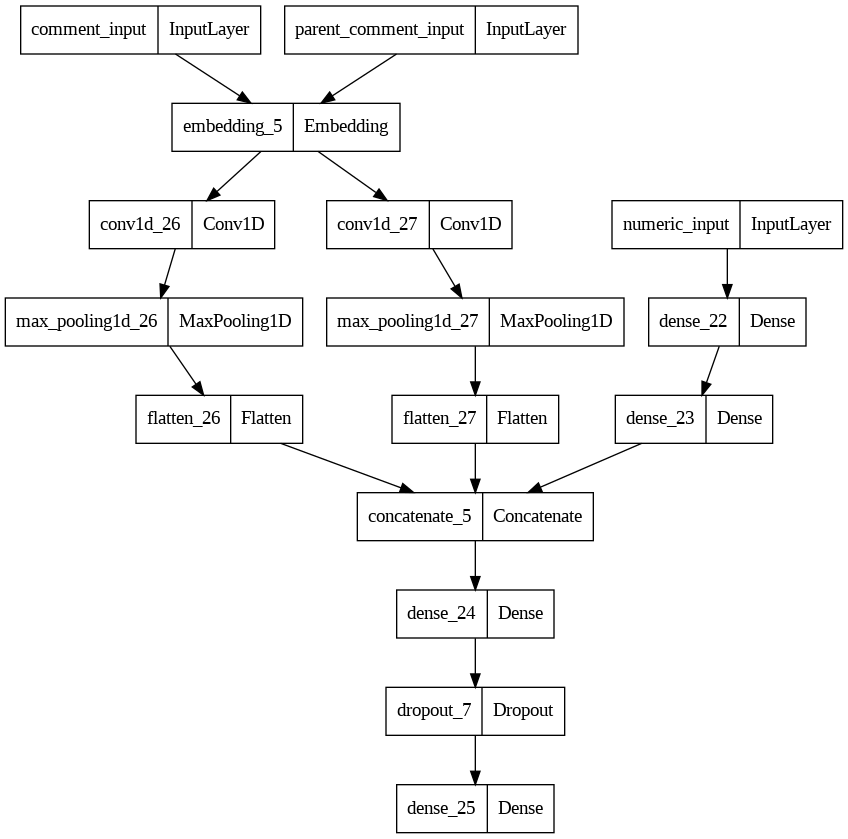

In [45]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout
from keras.models import Model



# tune pooling size
pool_size = 2

# smaller batch size for memory purposes
batch_size = 32

# Three model inputs so far
comment_input = Input(shape=(max_seq_length,), name='comment_input')
parent_comment_input = Input(shape=(max_seq_length,), name='parent_comment_input')
numeric_input = Input(shape=(X_numeric_scaled.shape[1],), name='numeric_input')

embedding_dim = 100
num_filters = 128
filter_size = 3

embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_length)
comment_embedding = embedding_layer(comment_input)
parent_comment_embedding = embedding_layer(parent_comment_input)


conv_comment = Conv1D(filters=num_filters,
                          kernel_size=filter_size,
                          padding='valid',
                          activation='relu',
                          strides=1)(comment_embedding)
conv_parent_comment = Conv1D(filters=num_filters,
                              kernel_size=filter_size,
                              padding='valid',
                              activation='relu',
                              strides=1)(parent_comment_embedding)

max_pool_comment = MaxPooling1D(pool_size=max_seq_length - filter_size + 1)(conv_comment)
max_pool_parent_comment = MaxPooling1D(pool_size=max_seq_length - filter_size + 1)(conv_parent_comment)

conv_blocks = []
conv_blocks.append(max_pool_comment)
conv_blocks.append(max_pool_parent_comment)


# numeric_dense = Dense(64, activation='relu')(numeric_input)
# numeric_dense = Dense(32, activation='relu')(numeric_dense)


flatten_tensors = [Flatten()(tensor) for tensor in conv_blocks]


numeric_dense = Dense(64, activation='relu')(numeric_input)
# numeric_dense = Dropout(0.5)(numeric_dense)
numeric_dense = Dense(32, activation='relu')(numeric_dense)



concatenated_final = concatenate(flatten_tensors + [numeric_dense], axis=-1)


dense = Dense(128, activation='relu')(concatenated_final)
dense = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(dense)


model2 = Model(inputs=[comment_input, parent_comment_input, numeric_input], outputs=output)

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()
plot_model(model2)






In [46]:
model2.fit({'comment_input': X_text_comment_pad, 'parent_comment_input': X_text_parent_comment_pad, 'numeric_input': X_numeric_scaled}, y_train, epochs=4, batch_size=batch_size, validation_split=0.1)




Epoch 1/4
18194/18194 [==============================] - 117s 6ms/step - loss: 0.5621 - accuracy: 0.7097 - val_loss: 0.5379 - val_accuracy: 0.7263
Epoch 2/4
18194/18194 [==============================] - 90s 5ms/step - loss: 0.5163 - accuracy: 0.7454 - val_loss: 0.5436 - val_accuracy: 0.7191
Epoch 3/4
18194/18194 [==============================] - 88s 5ms/step - loss: 0.4780 - accuracy: 0.7712 - val_loss: 0.5417 - val_accuracy: 0.7234
Epoch 4/4
18194/18194 [==============================] - 88s 5ms/step - loss: 0.4338 - accuracy: 0.7966 - val_loss: 0.5888 - val_accuracy: 0.7170


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Model

predictions = model2.predict({'comment_input': X_text_comment_pad_test,
                             'parent_comment_input': X_text_parent_comment_pad_test,
                             'numeric_input': X_numeric_scaled_test})

prediction_result = (predictions > 0.5).astype('int32')

accuracy = accuracy_score(y_test, prediction_result)
print('Accuracy: %f' % accuracy)


precision = precision_score(y_test, prediction_result)
print('Precision: %f' % precision)


recall = recall_score(y_test, prediction_result)
print('Recall: %f' % recall)


f1 = f1_score(y_test, prediction_result)
print('F1 score: %f' % f1)


predictions = predictions.flatten()
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)


5054/5054 [==============================] - 9s 2ms/step
Accuracy: 0.682224
Precision: 0.662234
Recall: 0.747416
F1 score: 0.702251
ROC AUC: 0.758511


#Next steps: Stacking Convolutional Layer, addings additional features, more parameter tuning
